![Coverphoto](https://raw.githubusercontent.com/VictorBChen/2021NewMexico/main/CoverPhoto.png)

# San Juan Well and Facility Analysis
This notebook documents the process and analysis of this portion of the project.

Code by Victor Chen, modified from code by 
[Christopher Reed - 2019-2020 Practicum Team](https://colab.research.google.com/drive/1eCyOE80wukuPjPqYm1bv0VvYrZiLqgXl?usp=sharing)

All files used in this analysis can be found in this [Github](https://github.com/VictorBChen/2021NewMexico)

### Installation and importation of required of packages
This analytical project requires many of Python's standard data science packages amongst geospatial processing packages. Altogether, these packages will enable us to fully analyze and investigate potential violations by facilities.


![Primary Data Science Packages](https://drive.google.com/uc?id=1XmpTYjrUTqtSMllT-4CXgbzofKUQ76L8)
Graphic by Christopher Reed

* [Pandas](https://pandas.pydata.org/)
* [NumPy](https://numpy.org/)
* [Matplotlib](https://matplotlib.org/)
* [Scikit-learn](https://scikit-learn.org/stable/)
* [Geopandas](https://geopandas.org/)
* [Fiona](https://fiona.readthedocs.io/en/latest/manual.html)

**Install packages required (Fiona, Geopandas)**

In [ ]:
%%capture
!pip install fiona
!pip install geopandas

**Import and load all required packages**

In [ ]:
from ftplib import FTP
import requests
import time
import fiona
import geopandas as gpd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib import animation, rc
import datetime
import seaborn as sns
from sklearn.cluster import DBSCAN
from geopy.distance import great_circle
from shapely.geometry import MultiPoint

### Fetching Data through NMED and NMOCD

Data collection begins with the New Mexico Environment Department (NMED) and New Mexico Oil Conservation Division (NMOCD). These official government websites contains up-to-date data available for public retrieval.

**NMED** provides information on facilities and its location, facility type, name, and emissions.

**NMOCD** provides a database housing all well information including location, emissions, operating company, and well specific dates such as spudding.

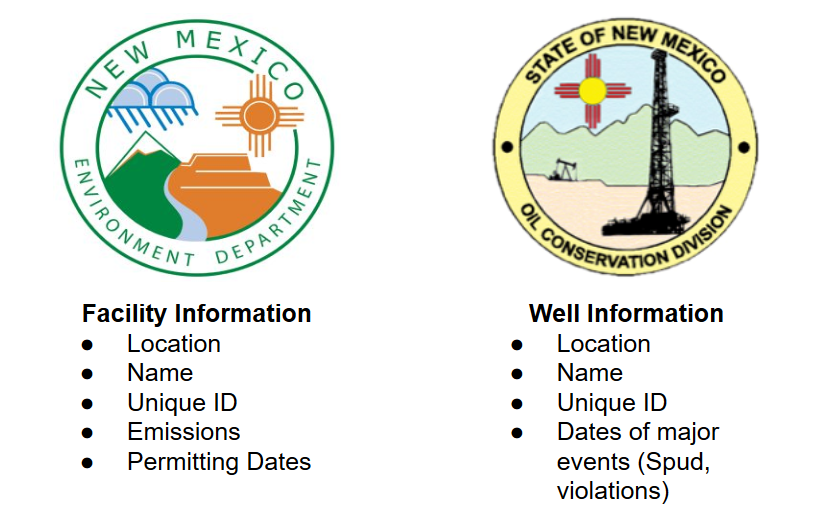

Image by Christopher Reed

**New Mexico Environment Department**

The NMED provides a monthly updated spreadsheet of facilities within New Mexico. The data can be found here in [ Current Permitting Activites](https://www.env.nm.gov/air-quality/aqb-p_current_permitting_activities/). However, it is important to note, at the time of this project, the spreadsheets were last updated on 01/05/2021.

**New Mexico Oil Conservation Division**
The NMOCD operates a database which includes biweekly updated geospatial datasets of all wells in New Mexico. This dataset can be obtained through the [NMOCD website](http://www.emnrd.state.nm.us/OCD/ocdgis.html) or direct connection to their [Public FTP website](ftp://164.64.106.6/Public/OCD/OCD%20GIS%20Data/). The files used during this project were downloaded on 04/24/2021.

**Download and read files**


In [ ]:
# # Retrieve, download, and unzip the well data set.
# # connect to NMOCD FTP

# ftp = FTP('164.64.106.6')
# ftp.login()

# #Move to directory
# ftp.cwd('/Public/OCD/OCD GIS Data/Geodatabase/')

# #Download file
# file = 'NMOCD_GISData.gdb.zip'
# ftp.retrbinary('RETR ' + file, open(file, 'wb').write)

# #Unzip the geodatabase
# !unzip /content/NMOCD_GISData.gdb.zip

# use this method as a backup method if the FTP website is down or if version on FTP is different
!wget https://github.com/VictorBChen/2021NewMexico/blob/main/Data/NMOCD_GISData.gdb.zip?raw=true
!unzip /content/NMOCD_GISData.gdb.zip

# Parse feature class from gdb
df_wells = gpd.read_file('/content/NMOCD_GISData.gdb')

Archive:  /content/NMOCD_GISData.gdb.zip
   creating: NMOCD_GISData.gdb/
  inflating: NMOCD_GISData.gdb/a00000001.freelist  
  inflating: NMOCD_GISData.gdb/a00000001.gdbindexes  
  inflating: NMOCD_GISData.gdb/a00000001.gdbtable  
  inflating: NMOCD_GISData.gdb/a00000001.gdbtablx  
  inflating: NMOCD_GISData.gdb/a00000001.TablesByName.atx  
  inflating: NMOCD_GISData.gdb/a00000002.gdbtable  
  inflating: NMOCD_GISData.gdb/a00000002.gdbtablx  
  inflating: NMOCD_GISData.gdb/a00000003.gdbindexes  
  inflating: NMOCD_GISData.gdb/a00000003.gdbtable  
  inflating: NMOCD_GISData.gdb/a00000003.gdbtablx  
  inflating: NMOCD_GISData.gdb/a00000004.CatItemsByPhysicalName.atx  
  inflating: NMOCD_GISData.gdb/a00000004.CatItemsByType.atx  
  inflating: NMOCD_GISData.gdb/a00000004.FDO_UUID.atx  
  inflating: NMOCD_GISData.gdb/a00000004.freelist  
  inflating: NMOCD_GISData.gdb/a00000004.gdbindexes  
  inflating: NMOCD_GISData.gdb/a00000004.gdbtable  
  inflating: NMOCD_GISData.gdb/a00000004.gdbtablx

**Libgeos must be reverted to a previous version for matplotlib's Basemap to function on Google Colab**

This process must be done after reading in the file otherwise an error occurs

In [ ]:
%%capture

##For Basemap to work in Google Colab
!apt-get install libgeos-3.5.0
!apt-get install libgeos-dev
!pip install https://github.com/matplotlib/basemap/archive/master.zip

!pip install pyproj==1.9.6

Here we import the basemap

In [ ]:
#Now we can import these
from mpl_toolkits.basemap import Basemap

Convert dates within the spreadsheets into datetime format to be used by code.

In [ ]:
#Convert spud date column to datetime.
df_wells['spud_date'] = pd.to_datetime(df_wells['spud_date'], errors = 'coerce')

#Remove excess white space
df_wells['type_code'] = df_wells['type_code'].str.replace(' ', '')

df_san_juan = df_wells[(df_wells['county'] == 'San Juan') &
                        (df_wells['status'] == 'Active')]

#Save raw data
df_wells.to_csv('nm_wells.csv')
df_san_juan.to_csv('sanjuan_active_wells.csv')

df_wells.head()

,id,name,type_code,type,status_code,status,ogrid,ogrid_name,district_code,district,county_code,county,ulstr,latitude,longitude,projection,directional_status,details,files,status2,symbology,year_spudded,spud_date,measured_vertical_depth,true_vertical_depth,pool_id_list,effective_date,plug_date,GlobalID,geometry
0,30-025-04504,EUNICE MONUMENT SOUTH UNIT #212,O,Oil,A,Active,5380,"XTO ENERGY, INC",1,Hobbs,25,Lea,I-05-21S-36E,32.513210,-103.281082,NAD83,V,https://wwwapps.emnrd.state.nm.us/ocd/ocdpermi...,http://ocdimage.emnrd.state.nm.us/imaging/Well...,A,OA,9999,NaT,3887.0,3887.0,"[23000] EUNICE MONUMENT, GRAYBURG-SAN ANDRES",2004-08-01T00:00:00+00:00,9999-12-31T00:00:00+00:00,{ACE1DF19-A921-49AC-ABE1-4AC4C837BA51},POINT (-103.28108 32.51321)
1,30-045-23649,UTE MOUNTAIN UTE #001,O,Oil,A,Active,148219,KEYSTONE ENERGY LLC,3,Aztec,45,San Juan,F-10-31N-15W,36.917633,-108.406952,NAD83,V,https://wwwapps.emnrd.state.nm.us/ocd/ocdpermi...,http://ocdimage.emnrd.state.nm.us/imaging/Well...,A,OA,1979,1979-07-24 00:00:00+00:00,1985.0,1985.0,[62510] VERDE GALLUP,1995-08-01T00:00:00+00:00,9999-12-31T00:00:00+00:00,{91BE505D-52D3-4B90-B234-BE3A482C5AD8},POINT (-108.40695 36.91763)
2,30-025-29601,EUNICE MONUMENT SOUTH UNIT #338,I,Injection,P,Plugged (site released),5380,"XTO ENERGY, INC",1,Hobbs,25,Lea,P-08-21S-36E,32.487686,-103.280731,NAD83,V,https://wwwapps.emnrd.state.nm.us/ocd/ocdpermi...,http://ocdimage.emnrd.state.nm.us/imaging/Well...,P,IP,9999,NaT,4250.0,4250.0,"[23000] EUNICE MONUMENT, GRAYBURG-SAN ANDRES",2004-08-01T00:00:00+00:00,2012-04-25T00:00:00+00:00,{C9F45D53-5A31-418F-AD9F-FB235EEE34F9},POINT (-103.28073 32.48769)
3,30-045-25440,HATCH #001,O,Oil,A,Active,371618,RELIABLE PRODUCTION LLC,3,Aztec,45,San Juan,C-11-29N-15W,36.745640,-108.389458,NAD83,V,https://wwwapps.emnrd.state.nm.us/ocd/ocdpermi...,http://ocdimage.emnrd.state.nm.us/imaging/Well...,A,OA,1982,1982-10-13 00:00:00+00:00,5174.0,5174.0,[11880] CHA CHA GALLUP,2017-03-13T00:00:00+00:00,9999-12-31T00:00:00+00:00,{6D2D6C07-C93B-4476-B1C5-74339B10C94B},POINT (-108.38946 36.74564)
4,30-039-26682,RINCON UNIT #229M,G,Gas,A,Active,372286,"ENDURING RESOURCES, LLC",3,Aztec,39,Rio Arriba,B-34-27N-07W,36.533649,-107.559242,NAD83,V,https://wwwapps.emnrd.state.nm.us/ocd/ocdpermi...,http://ocdimage.emnrd.state.nm.us/imaging/Well...,A,GA,2001,2001-04-25 00:00:00+00:00,7588.0,7588.0,[71599] BASIN DAKOTA (PRORATED GAS); [72319] B...,2017-11-14T00:00:00+00:00,9999-12-31T00:00:00+00:00,{37BF2E8A-0BBA-4F73-849C-B87E128A47BD},POINT (-107.55924 36.53365)


Facility data from NMED was downloaded manually on their website and uploaded into the Google Colab

In [ ]:
#Read in downloaded facilities data
!wget https://github.com/VictorBChen/2021NewMexico/blob/main/Data/FacilityData-21-01-05.csv?raw=true
facilities = pd.read_csv('/content/FacilityData-21-01-05.csv?raw=true')


--2021-05-23 23:18:23--  https://github.com/VictorBChen/2021NewMexico/blob/main/Data/FacilityData-21-01-05.csv?raw=true
Resolving github.com (github.com)... 140.82.113.4
Connecting to github.com (github.com)|140.82.113.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://github.com/VictorBChen/2021NewMexico/raw/main/Data/FacilityData-21-01-05.csv [following]
--2021-05-23 23:18:23--  https://github.com/VictorBChen/2021NewMexico/raw/main/Data/FacilityData-21-01-05.csv
Reusing existing connection to github.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/VictorBChen/2021NewMexico/main/Data/FacilityData-21-01-05.csv [following]
--2021-05-23 23:18:23--  https://raw.githubusercontent.com/VictorBChen/2021NewMexico/main/Data/FacilityData-21-01-05.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent

**Data Cleanup**

Cleaning up data and looking specifically for facilities in San Juan

In [ ]:
#Only oil and gas facilities in San Juan county
og_facilities = facilities[(facilities['Facility Type'].str.contains('O&G')) & (facilities['County'] == 'San Juan')]

og_facilities.head()

,Agency Interest #,Facility Type,Facility Status,Facility Classification,SIC Code,Facility Name,Physical Address,Municipality,County,State,Zip Code,Latitude,Longitude,Nox TPY,CO TPY,VOC TPY,PM10 TPY,SO2 TPY,Unnamed: 18,Unnamed: 19,Unnamed: 20,Unnamed: 21
537,1144,O&G-Tank Battery/Bulk Fuel Storage,Active,Minor,1311.0,SIMCOE - Tank Battery,1816 E Mojave,Farmington,San Juan,NM,87401,36.717713,-108.212075,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
538,1145,O&G-Compressor Station,Active,Minor,4922.0,Angel Peak Site 3 Compressor Station GCP1-1567,8 miles SE of Bloomfield,Bloomfield,San Juan,NM,87413,36.594111,-107.913667,25.9,92.6,94.85,NaN,NaN,NaN,NaN,NaN,NaN
539,1146,O&G-Compressor Station,Active,Synthetic Minor,4922.0,Ballard Compressor Station GCP1-1585,13 miles N of Nageezi,Nageezi,San Juan,NM,87037,36.460056,-107.753000,48.0,92.5,86.60,1.8,2.6,NaN,NaN,NaN,NaN
540,1147,O&G-Compressor Station,Active,Major-Title V,4922.0,Blanco Compressor Station A,0.5 miles N of Bloomfield,Bloomfield,San Juan,NM,87401,36.728333,-107.955833,1343.6,173.6,64.30,NaN,0.3,NaN,NaN,NaN,NaN
541,1148,O&G-Gas Plant,Active,Major-Title V,1311.0,Chaco Gas Plant,14 mi SW of Bloomfield,Bloomfield,San Juan,NM,87413,36.483056,-108.119722,2608.6,641.8,348.40,50.9,91.8,NaN,NaN,NaN,NaN


Sort well data for only wells in San Juan County that have been spudded 2010 and after. The wells must be active and be of type "O" for oil or "G" for gas.

In [ ]:
#Sort for only wells in San Juan County spudded 2010 and after
#Wells must be active and either a oil or gas well.
DecadeWell = df_san_juan[(df_wells['spud_date'].dt.year > 2009)]
DecadeWell_gas = DecadeWell[DecadeWell['type_code'] == 'G']
DecadeWell_oil = DecadeWell[DecadeWell['type_code'] == 'O']

/usr/local/lib/python3.7/dist-packages/geopandas/geodataframe.py:1299: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  result = super(GeoDataFrame, self).__getitem__(key)


### Visually plot data for analytical analysis
The datasets will be visually plotted to provide an overview of the data we are working with. This initial analysis will be able to provide information on:
* Extent of development within the San  Juan County
* Trends and patterns of wells spudded
* Provide details on which companies are spudding

Below are figures and summaries of this analysis.
---

![San Juan Spuds](https://raw.githubusercontent.com/VictorBChen/2021NewMexico/main/Visual%20Data/nm_spuds_sjcounty.gif)

This animated plot of San Juan County visualizes oil and gas well spudding in the recent decade, starting  from 2010. Spudding occured heavily in the eastern region of the county, especially in the south-east.

---

![Wells drilled each year](https://raw.githubusercontent.com/VictorBChen/2021NewMexico/main/Visual%20Data/numberSpudsbyYear.PNG)

Here, a plot was generated to show the number of wells drilled each year. Spudding was most prominent during the beginning of the decade, with a steady decline in recent years. This may be partially due to more optimal opportunities in the Permian Basin. 

---

![Wells drilled by company](https://raw.githubusercontent.com/VictorBChen/2021NewMexico/main/Visual%20Data/DrillingByCompany.PNG)

The 8 companies with the most wells spudded in San Juan County is visualized above. Hillcrop spudded the most wells since 2010 by far, with about 450 wells spudded altogether by the top four companies in the region.









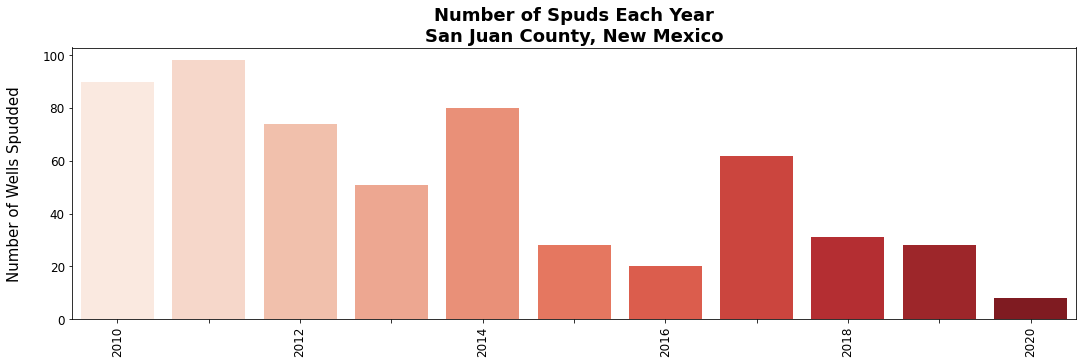

In [ ]:

#Filter to only wells in San Juan County that were spudded after 2010
df_wells_plot = df_wells[(df_wells['spud_date'].dt.year > 2009) & (df_wells['county'] == 'San Juan')]

#Group by years and count the spuds in each year
count_spuds = df_wells_plot.groupby(df_wells_plot['spud_date'].dt.year).count()
count_spuds= count_spuds.rename(columns = {'spud_date':'Num Spuds'})
count_spuds = count_spuds.reset_index()

#Barplot
fig, ax = plt.subplots(figsize = (18,5))
ax = sns.barplot(x = 'spud_date', y = 'Num Spuds', data = count_spuds, palette = 'Reds')
plt.xticks(rotation = 90)

#Format labels 
ax.set_title('Number of Spuds Each Year\nSan Juan County, New Mexico', size = 18, weight = 'bold')
ax.set_xlabel('')
ax.set_ylabel('Number of Wells Spudded', size = 15, labelpad = 20)
ax.tick_params(labelsize = 12)

#Every other x tick label visible
for label in ax.xaxis.get_ticklabels()[1::2]:
    label.set_visible(False)

**Create animated plot visualizing the spudding of wells across San Juan County**


In [ ]:
#Create a list of dfs that each have one more year's wells than the previous df
years_list = []
for year in np.arange(2010, 2021):
  df = df_san_juan[(df_san_juan['spud_date'].dt.year > 2009) & (df_san_juan['spud_date'].dt.year < year)]
  years_list.append(df)

print(years_list)

[Empty GeoDataFrame
Columns: [id, name, type_code, type, status_code, status, ogrid, ogrid_name, district_code, district, county_code, county, ulstr, latitude, longitude, projection, directional_status, details, files, status2, symbology, year_spudded, spud_date, measured_vertical_depth, true_vertical_depth, pool_id_list, effective_date, plug_date, GlobalID, geometry]
Index: [],                   id  ...                     geometry
664     30-045-35073  ...  POINT (-107.98277 36.84791)
1385    30-045-35066  ...  POINT (-107.77707 36.71282)
4661    30-045-35081  ...  POINT (-107.98277 36.84820)
5373    30-045-35052  ...  POINT (-108.30916 36.98471)
5541    30-045-35056  ...  POINT (-108.30913 36.99133)
...              ...  ...                          ...
104799  30-045-35075  ...  POINT (-107.85429 36.88908)
104977  30-045-35089  ...  POINT (-107.65627 36.60598)
108594  30-045-35072  ...  POINT (-107.64222 36.90641)
113028  30-045-35019  ...  POINT (-107.65879 36.28399)
113468  30-04

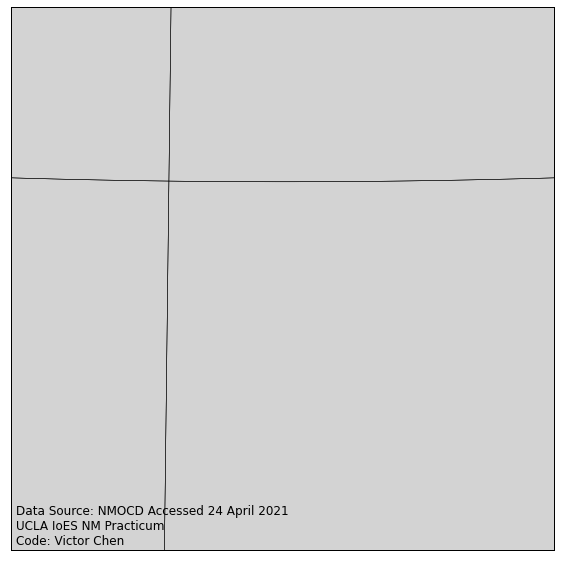

In [ ]:
#Create animation that does have a basemap

#Size of plot
fig, ax = plt.subplots(figsize = (10,10))

#Create static map centered on coords lat_0 and lon_0
m = Basemap(width=500000, height=500000, projection='lcc',
            resolution='c', lat_0= 36.2, lon_0=-107.8701)

#Add map elements
m.drawcoastlines()
m.drawmapboundary(fill_color='lightgrey')
m.drawstates()
m.drawcountries()

x,y = m(0, 0)
graph = m.plot(x, y, 'ro', markersize=4, alpha = 0.3)[0]
#ro
#Citation
ax.text(0.01,0.01, 'Data Source: NMOCD Accessed 24 April 2021\nUCLA IoES NM Practicum\nCode: Victor Chen', color = 'black', size = 12, transform = ax.transAxes)

#Set params for dynamic title
title = ax.text(0.525, 0.85,'', size = 20, color = 'black', transform=ax.transAxes, ha = 'center')

def init():
    graph.set_data([], [])
    return graph,

def animate(i):
    x, y = m(years_list[i]['longitude'].values, years_list[i]['latitude'].values)
    graph.set_data(x, y)
    title.set_text(u"Spudded O&G Wells in NM\nYear: {}".format(i + 2010))
    return graph,title


anim = animation.FuncAnimation(fig, animate, init_func=init,
                               frames=len(years_list), interval=150, blit=True)

plt.show()

In [ ]:
#Display the animation (likely not going to display on Github)
rc('animation', html='jshtml')
anim

In [ ]:
#Save as a mp4
anim.save('nm_spuds.mp4')

**Import New Mexico county boundaries**

We can now import the New Mexico County boundaries shapefile that can be donwloaded from the University of New Mexico [website](http://rgis.unm.edu/rgis6/).

In [ ]:
#Suppress outbook with inline magic
#%%capture

!wget https://github.com/VictorBChen/2021NewMexico/blob/main/fe_2007_35_county.zip?raw=true

#Unzip the shapefiles
!unzip '/content/fe_2007_35_county.zip?raw=true'

!unzip '/content/indigenous_land.zip'

--2021-05-23 23:21:18--  https://github.com/VictorBChen/2021NewMexico/blob/main/fe_2007_35_county.zip?raw=true
Resolving github.com (github.com)... 140.82.113.3
Connecting to github.com (github.com)|140.82.113.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://github.com/VictorBChen/2021NewMexico/raw/main/fe_2007_35_county.zip [following]
--2021-05-23 23:21:18--  https://github.com/VictorBChen/2021NewMexico/raw/main/fe_2007_35_county.zip
Reusing existing connection to github.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/VictorBChen/2021NewMexico/main/fe_2007_35_county.zip [following]
--2021-05-23 23:21:18--  https://raw.githubusercontent.com/VictorBChen/2021NewMexico/main/fe_2007_35_county.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.111.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.

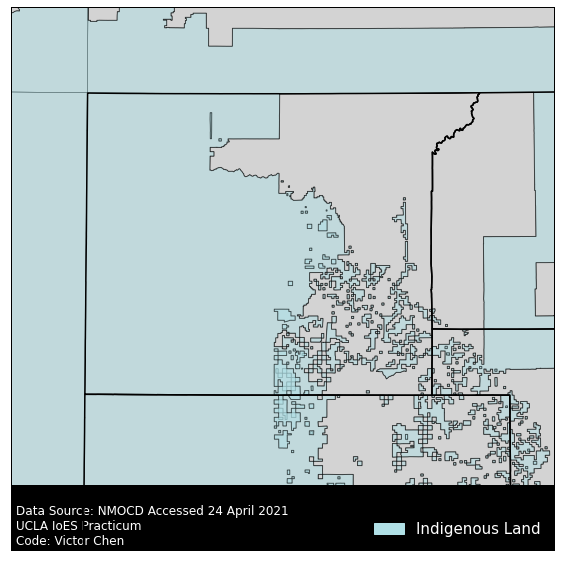

In [ ]:
#Need additional packages juse for this plot
from matplotlib.patches import Polygon
from matplotlib.collections import PatchCollection
from matplotlib.patches import PathPatch
import matplotlib.patches as mpatches
import matplotlib

#Expand animation file size
matplotlib.rcParams['animation.embed_limit'] = 2**128

#Size of plot
fig, ax = plt.subplots(figsize = (10,10))

#Create static map centered on coords lat_0 and lon_0
m = Basemap(width=200000, height=200000, projection='lcc',
            resolution='c', lat_0= 36.3882, lon_0=-108.2378)

#Add map elements including shapefiles
m.drawcoastlines()
m.drawmapboundary(fill_color='lightgrey')
m.drawstates()
m.drawcountries()
m.readshapefile('indigenous_land/indigenous_land_dissolve', 'indigenous_land_dissolve')
m.readshapefile('fe_2007_35_county', 'sj_county_dissolve', linewidth = 1.5, zorder = 10)

#Fill in the indigenous land shapefile with a color
map_patches = []
for info, shape in zip(m.indigenous_land_dissolve_info, m.indigenous_land_dissolve):
  map_patches.append(Polygon(np.array(shape), True) ) 
ax.add_collection(PatchCollection(map_patches, facecolor= 'powderblue', edgecolor='k', linewidths=1., zorder=2, alpha = 0.5, label = 'Indigenous Land'))

#Citation
ax.text(0.01,0.01, 'Data Source: NMOCD Accessed 24 April 2021\nUCLA IoES Practicum\nCode: Victor Chen', color = 'white', size = 12, transform = ax.transAxes, zorder = 8)

#Black rectangle on bottom of plot
rect = patches.Rectangle((0,0), width = 1, height = 0.12,
                         linewidth = 1, edgecolor = 'black', facecolor= 'black', transform = ax.transAxes, zorder = 7)
#Add the black rectangle
ax.add_patch(rect)

#Create a legend
blue_patch = mpatches.Patch(color='powderblue', label='Indigenous Land')
leg = plt.legend(handles=[blue_patch], loc = 'lower right', prop={'size': 15}, facecolor = 'none', edgecolor = 'none', )
leg.set_zorder(10)
for handle, text in zip(leg.legendHandles, leg.get_texts()):
    text.set_color('white')

#Plot points
x,y = m(0, 0)
graph = m.plot(x, y, 'ro', markersize=5, alpha = 0.3)[0]

#Set params for dynamic title
title = ax.text(0.525, 1.05,'', size = 20, color = 'black', transform=ax.transAxes, ha = 'center')

def init():
    graph.set_data([], [])
    return graph,

def animate(i):
    x, y = m(years_list[i]['longitude'].values, years_list[i]['latitude'].values)
    graph.set_data(x, y)
    title.set_text(u"Spudded O&G Wells in San Juan County, NM\nYear: {}".format(i + 2010))
    return graph,title


anim = animation.FuncAnimation(fig, animate, init_func=init,
                               frames=len(years_list), interval=150, blit=True)

plt.show()

In [ ]:
#view animations
anim

In [ ]:
#save the anmation as a mp4
anim.save('nm_spuds_sjcounty.mp4')

Since there are multiple companies drilling within San Juan County, lets visualize the number spudded.

In [ ]:
#Prepare data to count how many wells
df_wells_barplot = df_wells[(df_wells['county'] == 'San Juan') & (df_wells['spud_date'].dt.year > 2009) & (df_wells['status_code'] == 'A')]
df_wells_barplot = df_wells_barplot.groupby('ogrid_name').count().sort_values(by = 'id').reset_index()
df_wells_barplot = df_wells_barplot[df_wells_barplot['ogrid'] > 5]

#Create figure
fig,ax = plt.subplots(figsize = (8,5))
ax = sns.barplot(x = 'ogrid_name', y = 'id', data = df_wells_barplot, palette = 'Reds')

#Figure formatting
ax.set_xticklabels(['Huntington Energy', 'BP America',
                    'Juniper Resources', 'Logos',
                    'DJR', 'Dugan',
                    'Enduring', 'Hilcorp'])
plt.xticks(rotation = 45)

#Labels
ax.set_xlabel('')
ax.set_ylabel('Number of Wells', size = 15, labelpad = 20)
ax.set_title('Number of New Wells Spudded Since 2010\nSan Juan County, NM', size = 20, weight = 'bold')

**Visualize both oil and gas wells on a plotted map**


### Well and Facility Pairings


![WorkFlow - by Christopher Reed](https://raw.githubusercontent.com/VictorBChen/2021NewMexico/main/Google%20Colab%20visuals/workflow.png)
Image by Christopher Reed

Well and facility data will now be paired. Christopher Reed from the 2020 practicum team divised a method using DBSCAN which he calls DBSCAN Well Clustering and Well-Facility Distance Based Association. We will be using this method with slight modifications for our analysis.

Density-based spatial clustering of applications with noise or [DBSCAN](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.DBSCAN.html) allows for clustering points together by unsupervised machine learning classification algorithms.

More can be read from Christopher's google colab linked at the start of this page.

DBSCAN requires the input of two parameters:
* Maximum distance between two samples to be considered neighbors
* Minimum number of points allowed in a cluster

These parameters are modified in accordance to the application of DBSCAN. For our application, we are using a maximum distance of 400 meters. Newer well pads may contain only one well and so the minimum number of points allowed in a cluster is 1.

**Mapping of Gas and Oil Wells**

![oil and gas wells](https://raw.githubusercontent.com/VictorBChen/2021NewMexico/main/Google%20Colab%20visuals/clusteringPlots1.PNG)

Two plots were created to visualize wells. From 2010 to 2020, a total of 141 oil wells and a total of 341 gas wells have been spudded. Moreover, oil wells are closely clustered within the south-eastern region of the county while gas wells were spread more evenly.

![wells and facilities](https://raw.githubusercontent.com/VictorBChen/2021NewMexico/main/Google%20Colab%20visuals/clusteringplot3.PNG)

Next, we needed to prepare the clustered wells and facilities for pairing. To do this, we first visualized it on a plot. As seen above, a number of clustered wells have no facilities nearby.

![Oil well pads](https://raw.githubusercontent.com/VictorBChen/2021NewMexico/main/Google%20Colab%20visuals/OilWellPads-1.png)

Oil wells are placed ontop of pads and clustered closely together, usually with a facility on the same pad.

![Gas well pads](https://raw.githubusercontent.com/VictorBChen/2021NewMexico/main/Google%20Colab%20visuals/GasWellPads-1.png)

Gas wells are placed with more space in between. Meanwhile, facilities are also less likely to be in the same pad.

![Well Facility Pairings](https://raw.githubusercontent.com/VictorBChen/2021NewMexico/main/Google%20Colab%20visuals/clusteringPlots2.PNG)

Above are the final well cluster and facility pairings. All wells are paired with facilities within a 200 meter radius. Most oil well-clusters were paired, however, gas clusters had a significantly less chance of being paired. To combat this, unpaired gas well-clusters are then attempted to be paired with facilities within a 500 meter radius.

With this, we will be able to pair with NOI permits and show which have potential violations.



In [ ]:
#Plot all new gas wells
fig, ax = plt.subplots(figsize=[10, 6])
df_scatter = ax.scatter(DecadeWell_gas['longitude'], DecadeWell_gas['latitude'], c='k', alpha=0.9, s=40, marker = '+', label = 'Gas Wells')

#Find the number of gas wells
wells = DecadeWell_gas.shape[0]

#Format labels
ax.set_title('Gas wells 2010 and later\n' + str(wells) + ' Wells', size = 18, fontweight = 'bold')
ax.set_xlabel('Longitude', size = 15, labelpad = 20)
ax.set_ylabel('Latitude', size = 15, labelpad = 20)
ax.tick_params(labelsize = 12)

#ax.legend([df_scatter,], ['Enduring Gas Wells'], loc= 'lower left', prop = {'size':15})
ax.legend(loc= 'lower left', prop = {'size':15})
plt.show()

Here is where DBSCAN is being used to cluster wells together.

In [ ]:
#Matrix of all the well coordinates
coords = DecadeWell_gas[['latitude', 'longitude']].values

#DBSCAN requires two inputs other than data: minimum number of samples per cluster and the distance to associate points
kms_per_radian = 6371.0088
epsilon = 0.4 / kms_per_radian
db = DBSCAN(eps=epsilon, min_samples=1, algorithm='ball_tree', metric='haversine').fit(np.radians(coords))
cluster_labels = db.labels_
num_clusters = len(set(cluster_labels))
clusters = pd.Series([coords[cluster_labels == n] for n in range(num_clusters)])
print('Number of clusters: {}'.format(num_clusters))

The centerpoints of well-clusters are being found. The distance-between well clusters and facilities will be determined by the centerpoint.

In [ ]:
#Function to determine centermost points 
def get_centermost_point(cluster):
    centroid = (MultiPoint(cluster).centroid.x, MultiPoint(cluster).centroid.y)
    centermost_point = min(cluster, key=lambda point: great_circle(point, centroid).m)
    return tuple(centermost_point)

#Find centermost points in each cluster
centermost_points = clusters.map(get_centermost_point)

#Save centerpoints as a df
lats, lons = zip(*centermost_points)
rep_points = pd.DataFrame({'lon':lons, 'lat':lats})


rs = rep_points.apply(lambda row: DecadeWell_gas[(DecadeWell_gas['latitude']==row['lat'])&(DecadeWell_gas['longitude']==row['lon'])].iloc[0], axis=1)

#Create plot
fig, ax = plt.subplots(figsize=[10, 6])

#Plot centerpoints
rs_scatter = ax.scatter(rs['longitude'], rs['latitude'], c='#99cc99', edgecolor='None', alpha=0.7, s=120, label = 'Reduced Set')

#Plot individual well sites
df_scatter = ax.scatter(DecadeWell_gas['longitude'], DecadeWell_gas['latitude'], c='k', alpha=0.9, s=40, marker = '+', label = 'Full Set')


#Formatting
ax.set_title('2010 and After Gas Wells: Full Dataset vs DBSCAN Reduced Set', size = 18, fontweight = 'bold')
ax.set_xlabel('Longitude', size = 15, labelpad = 20)
ax.set_ylabel('Latitude', size = 15, labelpad = 20)
ax.tick_params(labelsize = 12)
ax.legend([df_scatter, rs_scatter], ['Gas Full set', 'Gas Reduced set'], loc='best')

ax.legend(loc= 'lower left', prop = {'size':15})
plt.show()

clusteredwellsDF = pd.DataFrame(rs)
clusteredwellsDF.to_csv('clusteredwellsdf.csv')

In [ ]:
#Empty column to store values
DecadeWell_gas['Cluster'] = np.nan

#Iterate through an iterable of length clusters
for i in range(len(clusters)):

  #Get ith cluster
  cluster = clusters[i]

  #Iterate through each coord pair in cluster
  for j in cluster:
   DecadeWell_gas.loc[(DecadeWell_gas['latitude'] == j[0]) & (DecadeWell_gas['longitude'] == j[1]), ['Cluster']] = int(i)


#Do the same with our centerpoints of wells. We want to know the cluster number associated with centerpoints.
rs['Cluster'] = np.nan

for i in range(len(clusters)):
  #Get ith cluster
  cluster = clusters[i]

  #Iterate through each coord pair in cluster
  for j in cluster:
   rs.loc[(rs['latitude'] == j[0]) & (rs['longitude'] == j[1]), ['Cluster']] = int(i)

rs.head()

In [ ]:
#Only oil and gas facilities in San Juan county
og_facilities = facilities[(facilities['Facility Type'].str.contains('O&G')) & (facilities['County'] == 'San Juan')]

##Filter out outliers by max lat and lon of well locations
#Bottom right: Must be less than or equal to this
max_lon = DecadeWell_gas['longitude'].max() + 0.1

#Bottom left: Must be greater than or equal to this 
min_lon = DecadeWell_gas['longitude'].min() - 0.1

#Top right: Must be less than or equal to this
max_lat = DecadeWell_gas['latitude'].max() +0.1

#Top: Must be greater than or equal to this
min_lat = DecadeWell_gas['latitude'].min() - 0.1

#Facilities inside the box (need to tweak boundaries)
og_facilities = og_facilities[(og_facilities['Latitude'].between(min_lat,max_lat, inclusive = True)) & (og_facilities['Longitude'].between(min_lon,max_lon, inclusive = True))]

In [ ]:
#Create figure
fig, ax = plt.subplots(figsize=[10, 6])

#Plot centerpoints of well clusters
rs_scatter = ax.scatter(rs['longitude'], rs['latitude'], c='#99cc99', edgecolor='None', alpha=0.7, s=120, label = 'Well Clusters')

#Plot filtered facilities
fac_scatter = ax.scatter(og_facilities['Longitude'], og_facilities['Latitude'], c='blue', edgecolor='None', alpha=0.7, s=25, label = 'O&G Facilities')

#Formatting
ax.set_title('2010 and After Gas Well Clusters vs Facility Location', size = 18, fontweight = 'bold')
ax.set_xlabel('Longitude', size = 15, labelpad = 20)
ax.set_ylabel('Latitude', size = 15, labelpad = 20)
ax.tick_params(labelsize = 12)

ax.legend([rs_scatter, fac_scatter], ['Gas Well Clusters', 'Facilities'], loc='upper right')

ax.legend(loc= 'lower left', prop = {'size':15})

plt.show()

In [ ]:
#Haversine function for distance calculation
import math

def haversine(coord1, coord2):
    R = 6372800  # Earth radius in meters
    lat1, lon1 = coord1
    lat2, lon2 = coord2
    
    phi1, phi2 = math.radians(lat1), math.radians(lat2) 
    dphi       = math.radians(lat2 - lat1)
    dlambda    = math.radians(lon2 - lon1)
    
    a = math.sin(dphi/2)**2 + \
        math.cos(phi1)*math.cos(phi2)*math.sin(dlambda/2)**2
    
    return 2*R*math.atan2(math.sqrt(a), math.sqrt(1 - a))

In [ ]:
#I want to have a seperate path for isolated well sites.
#So if no facilities within 200 m, I want to expand search radius to 500
#Need a running count of the number of faciliites per well

og_facilities['Cluster'] = np.nan

#How many facilities per center point?
isolated = []

#Iterate through center points
for i in rs['id'].unique():
  well_lat = rs[rs['id'] == i]['latitude'].values[0]
  well_lon = rs[rs['id'] == i]['longitude'].values[0]
  well_point = (well_lat, well_lon)

  #Get cluster values
  cluster_num = rs[rs['id'] == i]['Cluster'].values[0]
  
  count = 0

  #Iterate through facilities
  for j in og_facilities['Agency Interest #'].unique():
    fac_lat = og_facilities[og_facilities['Agency Interest #'] == j]['Latitude'].values[0]
    fac_lon = og_facilities[og_facilities['Agency Interest #'] == j]['Longitude'].values[0]
    fac_point = (fac_lat, fac_lon)

    distance = haversine(well_point, fac_point)

    if distance < 200:
      print(i, j, cluster_num)
      #Label it with cluster number of rs center point
      og_facilities.loc[og_facilities['Agency Interest #'] == j, ['Cluster']] = cluster_num

      count = count + 1
      
    #Too far away to be associated
    else:
      continue

  if count == 0:
    isolated.append(i)

  else:
    continue

In [ ]:
#Iterate through center points ##############################

for i in np.unique(isolated):
  well_lat = rs[rs['id'] == i]['latitude'].values[0]
  well_lon = rs[rs['id'] == i]['longitude'].values[0]
  well_point = (well_lat, well_lon)
  observed = rs[rs['id'] == i]

  #Get cluster values
  cluster_num = rs[rs['id'] == i]['Cluster'].values[0]

  count=0

  #Iterate through facilities
  for j in og_facilities['Agency Interest #'].unique():
    fac_lat = og_facilities[og_facilities['Agency Interest #'] == j]['Latitude'].values[0]
    fac_lon = og_facilities[og_facilities['Agency Interest #'] == j]['Longitude'].values[0]
    fac_point = (fac_lat, fac_lon)

    distance = haversine(well_point, fac_point)

    if distance < 500:
      print(i, j, cluster_num)
      og_facilities.loc[og_facilities['Agency Interest #'] == j, ['Cluster']] = cluster_num
      #Label it with cluster number of rs center point

      count = count + 1

    #Too far away to be associated
    else:
      continue


In [ ]:
#So now we can join the facilities and wells df

df_well_fac = DecadeWell_gas.merge(og_facilities, on = 'Cluster', how = 'inner', suffixes = ('_well', '_fac'))

df_well_fac_filter = df_well_fac[['spud_date', 'status', 'id', 'name', 'ogrid_name', 'latitude', 
                                  'longitude', 'Agency Interest #', 'Facility Name', 'Facility Type', 'Cluster', 'Latitude', 'Longitude',
                                  'Nox TPY','CO TPY','VOC TPY','PM10 TPY','SO2 TPY']]

#Rename columns
df_well_fac_filter = df_well_fac_filter.rename(columns = {'latitude':'Well Latitude',
                                    'longitude':'Well Longitude',
                                    'Latitude':'Facility Latitude',
                                    'Longitude':'Facility Longitude',
                                    'name':'Well Name',
                                    'API':'Well API'})

#Save as csv
df_well_fac_filter.to_csv('2010ToNow_gas_well_facility_match.csv')

In [ ]:
#Plot
fig, ax = plt.subplots(figsize= (10, 6))

#Scatter of well center points
rs_scatter = ax.scatter(rs['longitude'], rs['latitude'], c='#99cc99', edgecolor='None', alpha=0.7, s=120, label = 'Well Cluster')

#Scatter of associated facilities
fac_scatter = ax.scatter(df_well_fac_filter['Facility Longitude'], df_well_fac_filter['Facility Latitude'], c='blue', edgecolor='None', alpha=0.7, s=25, label = 'O&G Facilities')

#Formatting
ax.set_title('Gas Well and Facility Clusters', size = 18, fontweight = 'bold')
ax.set_xlabel('Longitude', size = 15, labelpad = 20)
ax.set_ylabel('Latitude', size = 15, labelpad = 20)
ax.tick_params(labelsize = 12)

ax.legend(loc= 'lower left', prop = {'size':15})
plt.show()
plt.savefig("GasFacilityCluster.png")


In [ ]:
#Plot all new oil wells
fig, ax = plt.subplots(figsize=[10, 6])
df_scatter = ax.scatter(DecadeWell_oil['longitude'], DecadeWell_oil['latitude'], c='k', alpha=0.9, s=40, marker = '+', label = 'Oil Wells')

#Find the number of wells after 2010
wells = DecadeWell_oil.shape[0]

#Format labels
ax.set_title('2010 and After New Oil Wells\n' + str(wells) + ' Wells', size = 18, fontweight = 'bold')
ax.set_xlabel('Longitude', size = 15, labelpad = 20)
ax.set_ylabel('Latitude', size = 15, labelpad = 20)
ax.tick_params(labelsize = 12)


ax.legend(loc= 'lower left', prop = {'size':15})
plt.show()

In [ ]:
#Matrix of all the well coordinates
coords = DecadeWell_oil[['latitude', 'longitude']].values

#DBSCAN requires two inputs other than data: minimum number of samples per cluster and the distance to associate points
kms_per_radian = 6371.0088
epsilon = 0.4 / kms_per_radian
db = DBSCAN(eps=epsilon, min_samples=1, algorithm='ball_tree', metric='haversine').fit(np.radians(coords))
cluster_labels = db.labels_
num_clusters = len(set(cluster_labels))
clusters = pd.Series([coords[cluster_labels == n] for n in range(num_clusters)])
print('Number of clusters: {}'.format(num_clusters))

In [ ]:
#Function to determine centermost points 
def get_centermost_point(cluster):
    centroid = (MultiPoint(cluster).centroid.x, MultiPoint(cluster).centroid.y)
    centermost_point = min(cluster, key=lambda point: great_circle(point, centroid).m)
    return tuple(centermost_point)

#Find centermost points in each cluster
centermost_points = clusters.map(get_centermost_point)

#Save centerpoints as a df
lats, lons = zip(*centermost_points)
rep_points = pd.DataFrame({'lon':lons, 'lat':lats})


rs = rep_points.apply(lambda row: DecadeWell_oil[(DecadeWell_oil['latitude']==row['lat'])&(DecadeWell_oil['longitude']==row['lon'])].iloc[0], axis=1)

#Create plot
fig, ax = plt.subplots(figsize=[10, 6])

#Plot centerpoints
rs_scatter = ax.scatter(rs['longitude'], rs['latitude'], c='#99cc99', edgecolor='None', alpha=0.7, s=120, label = 'Reduced Set')

#Plot individual well sites
df_scatter = ax.scatter(DecadeWell_oil['longitude'], DecadeWell_oil['latitude'], c='k', alpha=0.9, s=40, marker = '+', label = 'Full Set')

#Formatting
ax.set_title('2010 and After Wells: Full Dataset vs DBSCAN Reduced Set', size = 18, fontweight = 'bold')
text = str(wells) + ' Wells --> ' + str(num_clusters) + ' Clusters'  
ax.text(-108.10, 36.527, text, size = 14)
ax.set_xlabel('Longitude', size = 15, labelpad = 20)
ax.set_ylabel('Latitude', size = 15, labelpad = 20)
ax.tick_params(labelsize = 12)
ax.legend([df_scatter, rs_scatter], ['Oil Full set', 'Oil Reduced set'], loc='best')

ax.legend(loc= 'lower left', prop = {'size':15})
plt.show()

In [ ]:
#Empty column to store values
DecadeWell_oil['Cluster'] = np.nan

#Iterate through an iterable of length clusters
for i in range(len(clusters)):

  #Get ith cluster
  cluster = clusters[i]

  #Iterate through each coord pair in cluster
  for j in cluster:
   DecadeWell_oil.loc[(DecadeWell_oil['latitude'] == j[0]) & (DecadeWell_oil['longitude'] == j[1]), ['Cluster']] = int(i)


#Do the same with our centerpoints of wells. We want to know the cluster number associated with centerpoints.
rs['Cluster'] = np.nan

for i in range(len(clusters)):
  #Get ith cluster
  cluster = clusters[i]

  #Iterate through each coord pair in cluster
  for j in cluster:
   rs.loc[(rs['latitude'] == j[0]) & (rs['longitude'] == j[1]), ['Cluster']] = int(i)

rs.head()

In [ ]:
#Only oil and gas facilities in San Juan county
og_facilities = facilities[(facilities['Facility Type'].str.contains('O&G')) & (facilities['County'] == 'San Juan')]

##Filter out outliers by max lat and lon of well locations
#Bottom right: Must be less than or equal to this
max_lon = DecadeWell_oil['longitude'].max() + 0.1

#Bottom left: Must be greater than or equal to this 
min_lon = DecadeWell_oil['longitude'].min() - 0.1

#Top right: Must be less than or equal to this
max_lat = DecadeWell_oil['latitude'].max() +0.1

#Top: Must be greater than or equal to this
min_lat = DecadeWell_oil['latitude'].min() - 0.1

#Facilities inside the box (need to tweak boundaries)
og_facilities = og_facilities[(og_facilities['Latitude'].between(min_lat,max_lat, inclusive = True)) & (og_facilities['Longitude'].between(min_lon,max_lon, inclusive = True))]

In [ ]:
#Create figure
fig, ax = plt.subplots(figsize=[10, 6])

#Plot centerpoints of well clusters
rs_scatter = ax.scatter(rs['longitude'], rs['latitude'], c='#99cc99', edgecolor='None', alpha=0.7, s=120, label = 'Well Clusters')

#Plot filtered facilities
fac_scatter = ax.scatter(og_facilities['Longitude'], og_facilities['Latitude'], c='blue', edgecolor='None', alpha=0.7, s=25, label = 'O&G Facilities')


#Formatting
ax.set_title('2010 and After Oil Well Clusters vs Facility Location', size = 18, fontweight = 'bold')
ax.set_xlabel('Longitude', size = 15, labelpad = 20)
ax.set_ylabel('Latitude', size = 15, labelpad = 20)
ax.tick_params(labelsize = 12)

ax.legend([rs_scatter, fac_scatter], ['Oil Well Clusters', 'Facilities'], loc='upper right')

ax.legend(loc= 'lower left', prop = {'size':15})
plt.show()
plt.savefig("OilClusterVsFacilities")

In [ ]:
#Haversine function for distance calculation
import math

def haversine(coord1, coord2):
    R = 6372800  # Earth radius in meters
    lat1, lon1 = coord1
    lat2, lon2 = coord2
    
    phi1, phi2 = math.radians(lat1), math.radians(lat2) 
    dphi       = math.radians(lat2 - lat1)
    dlambda    = math.radians(lon2 - lon1)
    
    a = math.sin(dphi/2)**2 + \
        math.cos(phi1)*math.cos(phi2)*math.sin(dlambda/2)**2
    
    return 2*R*math.atan2(math.sqrt(a), math.sqrt(1 - a))

In [ ]:
og_facilities['Cluster'] = np.nan

#Iterate through center points
for i in rs['id'].unique():
  well_lat = rs[rs['id'] == i]['latitude'].values[0]
  well_lon = rs[rs['id'] == i]['longitude'].values[0]
  well_point = (well_lat, well_lon)

  #Get cluster values
  cluster_num = rs[rs['id'] == i]['Cluster'].values[0]

  #Iterate through facilities
  for j in og_facilities['Agency Interest #'].unique():
    fac_lat = og_facilities[og_facilities['Agency Interest #'] == j]['Latitude'].values[0]
    fac_lon = og_facilities[og_facilities['Agency Interest #'] == j]['Longitude'].values[0]
    fac_point = (fac_lat, fac_lon)

    distance = haversine(well_point, fac_point)

    if distance < 200:
      print(i, j, cluster_num)
      #Label it with cluster number of rs center point
      og_facilities.loc[og_facilities['Agency Interest #'] == j, ['Cluster']] = cluster_num
      
    #Too far away to be associated
    else:
      continue

In [ ]:
DecadeWell_oil.to_csv("OilWellclusterPre-pairing.csv")

In [ ]:
#So now we can join the facilities and wells df

df_well_fac = DecadeWell_oil.merge(og_facilities, on = 'Cluster', how = 'inner', suffixes = ('_well', '_fac'))

df_well_fac_filter = df_well_fac[['spud_date', 'status', 'id', 'name', 'ogrid_name', 'latitude', 
                                  'longitude', 'Agency Interest #', 'Facility Name', 'Facility Type', 'Cluster', 'Latitude', 'Longitude',
                                  'Nox TPY','CO TPY','VOC TPY','PM10 TPY','SO2 TPY']]

#Rename columns
df_well_fac_filter = df_well_fac_filter.rename(columns = {'latitude':'Well Latitude',
                                    'longitude':'Well Longitude',
                                    'Latitude':'Facility Latitude',
                                    'Longitude':'Facility Longitude',
                                    'name':'Well Name',
                                    'API':'Well API',
                                    'AI':'Facility AI'})

#Save as csv
df_well_fac_filter.to_csv('2010ToNow_oil_well_facility_match.csv')

In [ ]:
#Plot
fig, ax = plt.subplots(figsize= (10, 6))

#Scatter of well center points
rs_scatter = ax.scatter(rs['longitude'], rs['latitude'], c='#99cc99', edgecolor='None', alpha=0.7, s=120, label = 'Well Cluster')

#Scatter of associated facilities
fac_scatter = ax.scatter(df_well_fac_filter['Facility Longitude'], df_well_fac_filter['Facility Latitude'], c='blue', edgecolor='None', alpha=0.7, s=25, label = 'O&G Facilities')

#Formatting
ax.set_title('2010 and After Oil Well Clusters vs Facility Location', size = 18, fontweight = 'bold')
ax.set_xlabel('Longitude', size = 15, labelpad = 20)
ax.set_ylabel('Latitude', size = 15, labelpad = 20)
ax.tick_params(labelsize = 12)

ax.legend(loc= 'lower left', prop = {'size':15})
plt.show()
plt.savefig("OilFacilityCluster")


### Facility pairings to NOI issue Dates

Unfortunately, NMED and NMOCD do not provide NOI peremit documents to the public. To get these permits, we filed requests to NMED. Unlike last year's practicum team, NMED delivered the NOIs in the form of organized excel sheets.

The spud dates of wells were then compared to permit issue dates through the use of Facility AI IDs.

![facility NOI permitting timeline](https://raw.githubusercontent.com/VictorBChen/2021NewMexico/main/Visual%20Data/NM%20Oil%20and%20Gas%20Well%20Permitting.PNG)

A total of 243 well-facility clusters were matched with NOIs. Out of 243, 95 were observed to have spudded before the first permit issue date, resulting in **39%** potential violation rate.

![link text](https://github.com/VictorBChen/2021NewMexico/blob/main/Google%20Colab%20visuals/spudtimeViolation.PNG?raw=true)

Another visualization of the data shows the number of days wells were spudding before NOI permit issuance. Most potential violations were wells spudding up to 180 days before they received permits.

In [ ]:
decade_gasfacility = pd.read_csv('/content/2010ToNow_gas_well_facility_match.csv')
decade_oilfacility = pd.read_csv('/content/2010ToNow_oil_well_facility_match.csv')

#Concat them all together
facility_well_match = pd.concat([decade_gasfacility, decade_oilfacility])
facility_well_match = facility_well_match.drop(columns = ['Unnamed: 0'])
facility_well_match.head()

facility_well_match.to_csv("test2.csv")


In [ ]:
#Clean
#Column naming convention
facility_well_match = facility_well_match.rename(columns = {'Initial APD':'initial_apd',
                                                            'Spud Date':'spud_date',
                                                            'id':'well_api',
                                                            'Well Name':'well_name',
                                                            'Well Latitude':'well_latitude',
                                                            'Well Longitude':'well_longitude',
                                                            'Facility AI':'facility_ai',
                                                            'Facility Name':'facility_name',
                                                            'Cluster':'cluster',
                                                            'Facility Latitude':'facility_latitude',
                                                            'Facility Longitude':'facility_longitude',
                                                            'Industry':'industry'})
#Datetime implementation
#facility_well_match['initial_apd'] = pd.to_datetime(facility_well_match['initial_apd'])
facility_well_match['spud_date'] = pd.to_datetime(facility_well_match['spud_date'])
facility_well_match['spud_date'] = facility_well_match['spud_date'].dt.tz_localize(None)

#Inspect
facility_well_match.head()

In [ ]:
!wget https://raw.githubusercontent.com/VictorBChen/2021NewMexico/main/Data/San%20Juan%20NOI%202010_2020.xls.csv
df_noi = pd.read_csv('/content/San Juan NOI 2010_2020.xls.csv')

#Clean dataset
#Drop extra rows (we know all rows should have an ai number)
df_noi = df_noi.dropna(subset = ['master_ai_id'])

#Convert ai number to int
df_noi['master_ai_id'] = pd.to_numeric(df_noi['master_ai_id'], downcast = 'integer')

#Clean column names
# df_noi = df_noi.rename(columns = {'date_sent_to_nmed (mm/dd/yyyy)':'date_sent_to_nmed'})

#Convert dates to datetime
# df_noi['date_sent_to_nmed'] = pd.to_datetime(df_noi['date_sent_to_nmed'])
df_noi['received_date'] = pd.to_datetime(df_noi['received_date'])
df_noi['issue_date'] = pd.to_datetime(df_noi['issue_date'])

#Keep a complete copy
df_noi_complete = df_noi

#Drop extra columns
# df_noi = df_noi.drop(columns = ['gdrive_link', 'comments'])

#Inspect
df_noi.head()


In [ ]:
df = facility_well_match.merge(df_noi, how = 'outer', left_on = 'Agency Interest #', right_on = 'master_ai_id')

df.head()

In [ ]:
def violation_detection(x):
  if x['spud_date'] < x['issue_date']:
    return 'Yes'

  else:
    return 'No'

In [ ]:
#Remove duplicate rows
well_fac = facility_well_match.drop_duplicates()

#Perform inner join
df_complete = df_noi.merge(well_fac, how = 'inner', left_on = 'master_ai_id', right_on = 'Agency Interest #')

#Apply violation detection function
df_complete['potential_violation']= df_complete.apply(violation_detection, axis = 1)

#Keep a subset of columns
df = df_complete[['well_name', 'master_ai_id', 'permit_no', 'well_api','spud_date','received_date', 'issue_date', 'potential_violation']]

#Inspect
df.head()

In [ ]:
#Remove rows that have a revised noi
df_original_noi = df_complete[~df_complete['permit_no'].str.contains('R')]
df_original_noi_all_columns = df_complete[~df_complete['permit_no'].str.contains('R')]

##Save a cleaned copy as a csv
#Drop duplicate columns
df_original_noi_csv = df_original_noi_all_columns.drop(columns = ['Agency Interest #'])
# df_original_noi_csv = df_original_noi_csv.rename(columns = {'facility_name_y':'facility_name'})

#Save as csv with binary value for violations
def yes_no(x):
  if x == 'Yes':
    return 1
  if x == 'No':
    return 0

#Apply function
df_original_noi_csv['binary_violation'] = df_original_noi['potential_violation'].apply(yes_no)

#Save output as csv
df_original_noi_csv.to_csv('well_facility_violations.csv')

Time to Plot


In [ ]:
#Number of original nois
num_og_nois = df_original_noi.shape[0]

#When plotting we want to spread out each "timeline" so multiply by three to make space
df_original_noi['Plotting Line'] = np.arange(0,num_og_nois*3, 3)

#Find the index positions of the violations. Use the "plotting line" based index
violation_lines = df_original_noi[df_original_noi['potential_violation'] == 'Yes']['Plotting Line']

#Find the minimum date and the maximum date overall
min_date = np.min([df_original_noi['spud_date'].min(), df_original_noi['received_date'].min(), df_original_noi['issue_date'].min()])
max_date = np.max([df_original_noi['spud_date'].max(), df_original_noi['received_date'].max(), df_original_noi['issue_date'].max()])

In [ ]:
fig, ax = plt.subplots(figsize = (30,10))
ax.scatter(np.arange(0,num_og_nois*3, 3), df_original_noi['spud_date'], color = 'Red', label = 'SPUD Date')
ax.scatter(np.arange(0,num_og_nois*3, 3), df_original_noi['issue_date'], color = 'Yellow', label = 'NOI Issue Date')
ax.scatter(np.arange(0,num_og_nois*3, 3), df_original_noi['received_date'], color = 'Green', label = 'NOI Application Received')

ax.vlines(violation_lines.values, ymin = min_date, ymax = max_date, linestyles = 'dashed', color = 'black', label = 'Potential Violation')

ax.set_ylabel('Date', size = 16, labelpad = 20)
ax.set_xlabel('Well and Facility Pair', size = 20, labelpad = 20)
ax.set_title('NM Oil and Gas Well Permitting\nTimeline Progression', size = 22)
ax.xaxis.set_tick_params(labelsize=17)
ax.yaxis.set_tick_params(labelsize=17)
plt.xticks([])

plt.legend(ncol = 2, prop = {'size':15}, bbox_to_anchor = (0.975,-0.08), fancybox = True)

plt.savefig('violations.jpg', bbox_inches = 'tight')

In [ ]:
#Only look at violations
violations = df_original_noi[df_original_noi['potential_violation'] == 'Yes']

#Find number of days spud ocurred before NOI was processed
violations['days_before'] = violations['issue_date'] - violations['spud_date'] 
violations['days_before'] = violations['days_before'].dt.days

days_30 = np.sum(violations['days_before'] < 30)
days_90 = np.sum((violations['days_before'] >= 30) & (violations['days_before'] < 90))
days_180 = np.sum((violations['days_before'] >= 90) & (violations['days_before'] < 180))
days_365 = np.sum((violations['days_before'] >= 180) & (violations['days_before'] < 365))
days_730 = np.sum((violations['days_before'] >= 365) & (violations['days_before'] < 730))
days_730_plus = np.sum(violations['days_before'] >= 730)

heights = [days_30, days_90, days_180, days_365, days_730, days_730_plus]
bar_labs = ('< 30 Days', '30 < Days < 90', '90 < Days < 180', '180 < Days < 365', '1 < Years < 2', '> 2 Years')
y_pos = np.arange(len(bar_labs))

#Bar plot
fig, ax = plt.subplots(figsize = (8,5))
plt.bar(y_pos, heights, color = 'plum')
plt.xticks(y_pos, bar_labs, rotation = 45)

plt.title('Number of Days Spud Occured Before NOI Processed', size = 16)
plt.ylabel('Number of Well-Facility Pairs', size = 14)
plt.show()